In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [2]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) 
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [3]:
df = pd.read_csv('D:/kursi/dz_2/ab_test_inference/ab_test_ensembles.csv')
df

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
...,...,...,...,...,...,...,...,...
294473,497bf0f8-0092-4736-8ae7-775b6cc9736c,2022-05-03 22:28:38.630509,control,standard,0,United Kingdom,58+,new_user
294474,6cb20e62-e49d-41cf-97da-0e11cb439dca,2022-05-12 00:51:57.078372,control,standard,0,United Kingdom,42-49,new_user
294475,d307b0ad-92a1-409c-a2d2-da8f4a118576,2022-05-22 11:45:03.439544,control,standard,0,United Kingdom,18-25,registered_user
294476,c6bd8da5-2114-4fd4-92c6-e4b11a8be4dc,2022-05-15 01:20:28.957438,control,standard,0,United Kingdom,50-57,new_user


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [4]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [5]:
sessions = df['variants'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 2 пользователей, которые не уникальны в нашей выборке.


In [6]:
df.variants.value_counts()

standard               147239
svm_ensemble_v_1_22    147239
Name: variants, dtype: int64

In [7]:
users_to_drop = sessions[sessions > 1].index
# Проверяем вхождения, знак ~ логическо нет
df = df[~df['user_id'].isin(users_to_drop)]
print(f"Количество пользователей без дубликтов {df.shape[0]}")

Количество пользователей без дубликтов 294478


In [13]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.shape

(9440, 8)

In [18]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [19]:
ab_df.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

In [9]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


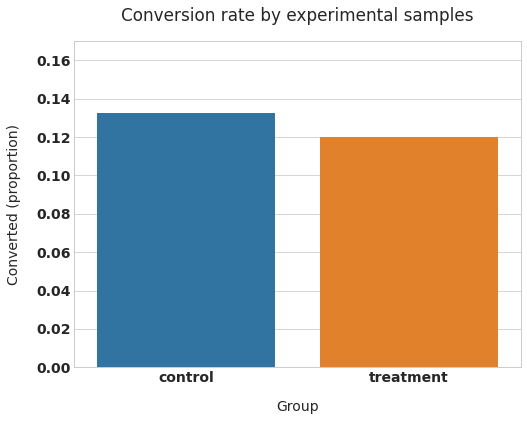

In [10]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [11]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


### Полученное значение p-value говорит о том, что у нас недостаточно оснований для отклонения нулевой гипотезы, и мы принимаем, что H0=H1 

## 2 вариант( новая\старая версия для старых клиентов)

In [35]:
control_sample = df[(df['user_type'] == 'registered_user') & (df['variants'] == 'standard') ]
treatment_sample = df[(df['user_type'] == 'registered_user') & (df['variants'] == 'svm_ensemble_v_1_22') ]

In [36]:

ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.shape

(147240, 8)

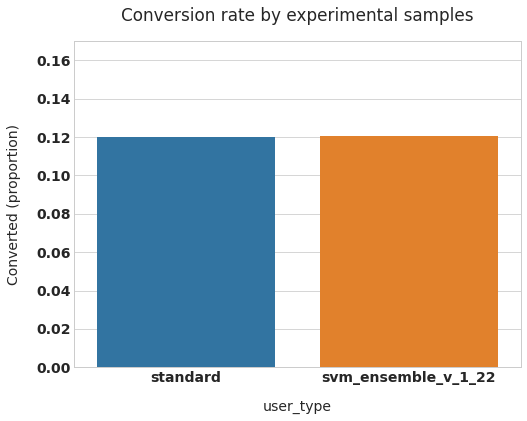

In [38]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['variants'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('user_type', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [40]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['variants'] == 'standard']['converted']
treatment_results = ab_df[ab_df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.34
p-value: 0.735
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


### Полученное  значение p-value говорит о том, что верна первая гипотеза H0=H1 

## 3 вариант( новая/старая версия для новых клиентов)

In [41]:
control_sample = df[(df['user_type'] == 'new_user') & (df['variants'] == 'standard') ]
treatment_sample = df[(df['user_type'] == 'new_user') & (df['variants'] == 'svm_ensemble_v_1_22') ]

In [42]:

ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,57c2fe74-e0be-44bc-823e-b38ff7daf399,2022-05-24 11:55:51.084801,control,standard,0,United Kingdom,58+,new_user
1,1f27a06c-4b31-4604-b4cb-46b7010e6e09,2022-05-17 20:33:37.428378,control,standard,0,United Kingdom,26-33,new_user
2,9e1170d4-f2c1-44a0-8eb2-41d2cb70c90c,2022-05-23 11:38:29.592148,control,standard,0,United Kingdom,34-41,new_user
3,c120a853-6cd3-4ddb-a11b-36ee41c72860,2022-05-13 17:22:57.182769,control,standard,0,United Kingdom,26-33,new_user
4,421c3d3b-c2f6-4230-be4a-d9f87bb5c4e7,2022-05-11 22:24:44.226492,control,standard,0,United Kingdom,42-49,new_user


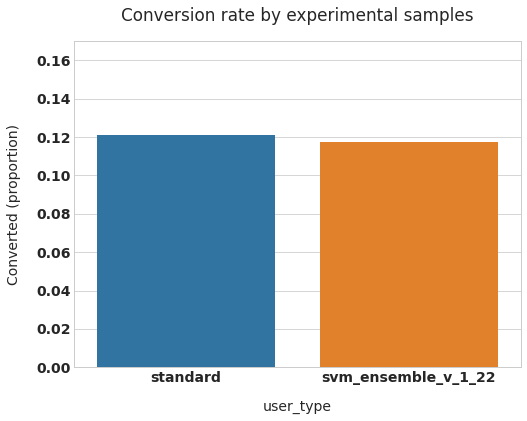

In [43]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['variants'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('user_type', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [45]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['variants'] == 'svm_ensemble_v_1_22']['converted']
treatment_results = ab_df[ab_df['variants'] == 'standard']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -2.28
p-value: 0.023
CI 95% for control group: [0.115, 0.120]
CI 95% for treatment group: [0.119, 0.123]


## Полученный уровень p-value дает нам возможность отбросить нулевую гипотезу о равности влияния версии. Принимаем вторую гипотезу.